#PROYECTO FINAL INTELIGENCIA ARTIFICAL


# Cargamos librerias




In [ ]:
# #importamos las librerias necesarias
import scipy.io as sio
# libreria para hacer graficos tipos matlab (pyplot)
import matplotlib.pyplot as plt
#libreria de manejo de arreglos de grandes dimensiones (a diferencia de las listas basicas de python)
import numpy as np
#librerias matematicas
import scipy.signal as signal
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.decomposition import FastICA
#import argparse
import scipy.io as sio
import numpy as np
from scipy.signal import butter, filtfilt
!pip install mne
from mne.decoding import CSP
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from KUR import KUR
#import pandas as pd
from sklearn import svm
from sklearn.naive_bayes import GaussianNB


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.1 MB/s 


#Cargamos la señal eeg

In [ ]:
#cargamos el dataset
from google.colab import drive
drive.mount('/content/drive')#se conecta con el drive
#asegurarse de tener un acceso directo en el drive de la carpeta que contiene 9 datasets
filename='/content/drive/MyDrive/bioingenieria/Dataset_IA/NEW_22ch_A01.mat'  #se debe colocar la ruta de un solo dataset
mat_contents = sio.loadmat(filename)#se debe colocar la ruta de un solo dataset

#los datos se cargan como un diccionario, se puede evaluar los campos que contiene
print("Los campos cargados son: " + str(mat_contents.keys()))

#queremos extraer solamente la señal eeg
data=sio.loadmat(filename)["X"]
#Mostramos las dimensiones de la señal
dims_control = [sio.loadmat(filename)["X"].shape ]
print(dims_control)

Mounted at /content/drive


FileNotFoundError: ignored

# Graficamos 

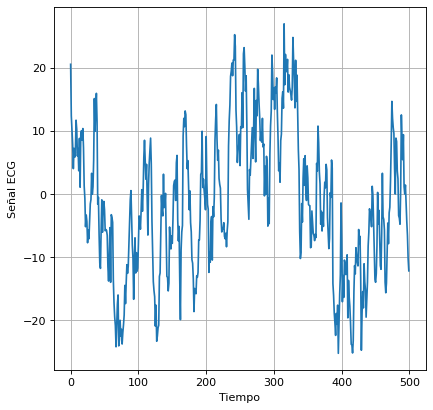

In [ ]:

#Grafico la señal ECG sin filtrar
data1=data[:,0,0]
#data2=data1.reshape(1,11000)
plt.figure(figsize=(6, 6), dpi=80)
 #se establece un tamaño del figure con el fin de que la grafica se vea de manera adecuada 
plt.plot(data1) 
#se grafica la señal que se desea observar 
plt.xlabel('Tiempo') 
#se nombra el eje x
plt.ylabel('Señal ECG') 
#se nombra el eje y
plt.grid() # se activa la cuadricula en la grafico

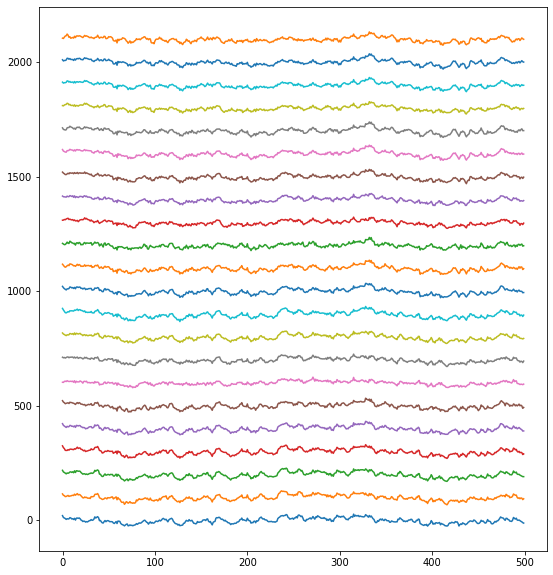

In [ ]:


#creamos el lienzo
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 2)
#graficamos la cantidad de canales que queramos
for canal in range(data.shape[1]):
  ax.plot( data[:,canal,0] + canal*100)

plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1440x720 with 0 Axes>

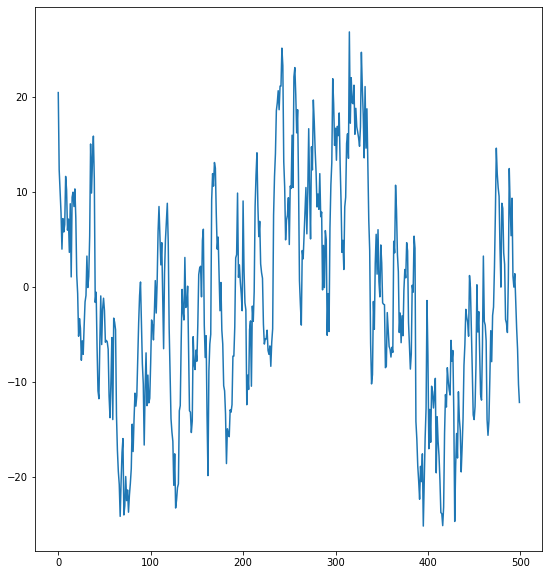

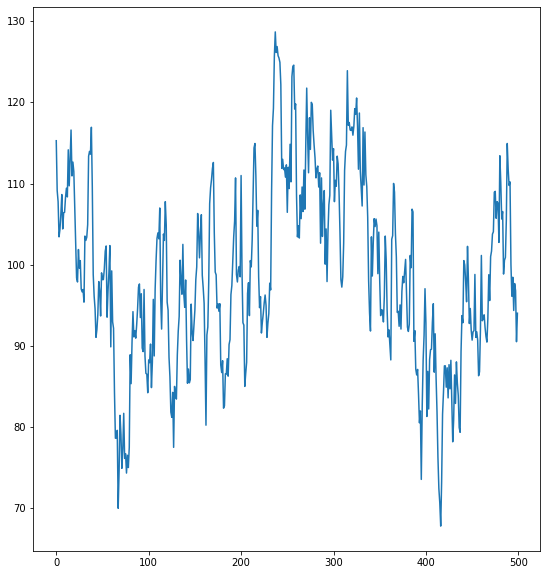

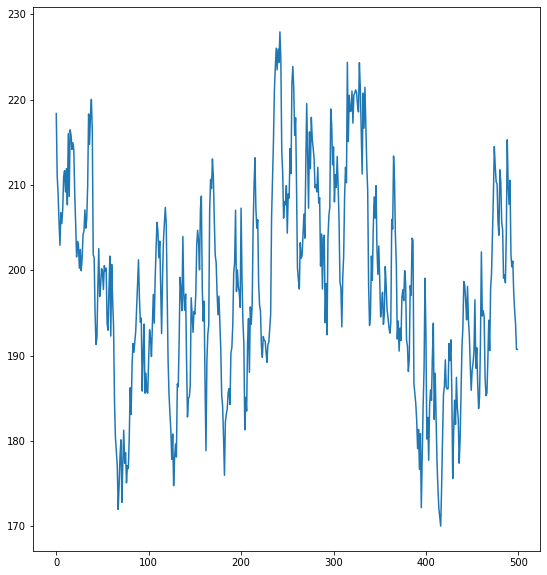

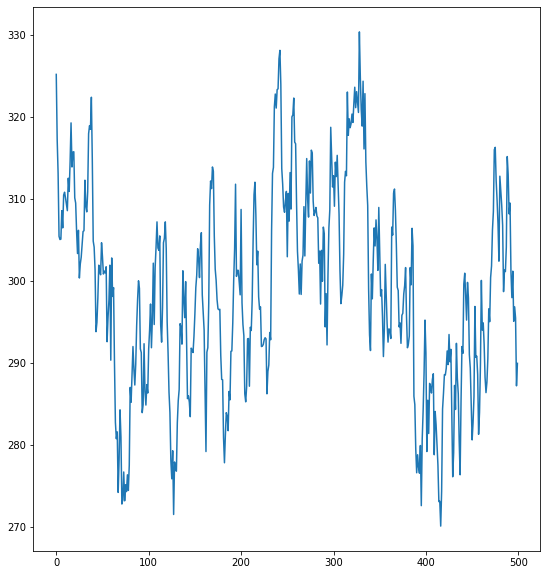

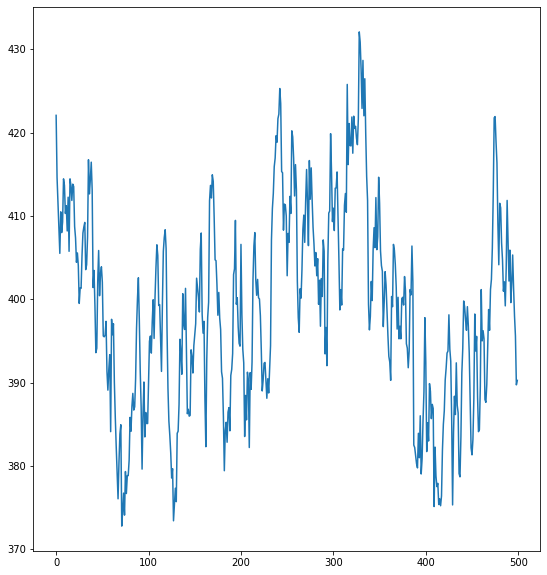

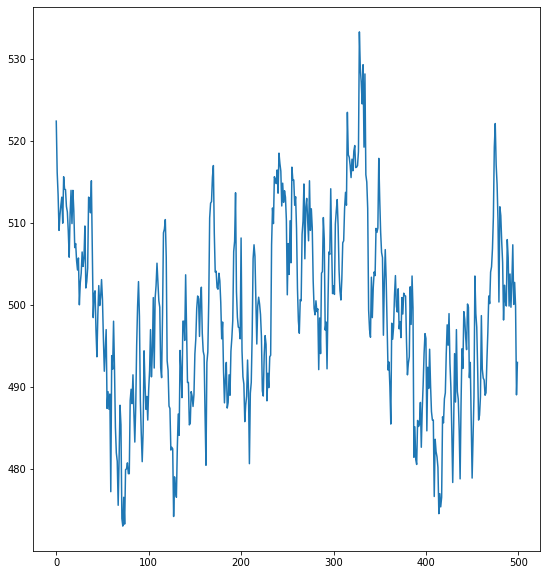

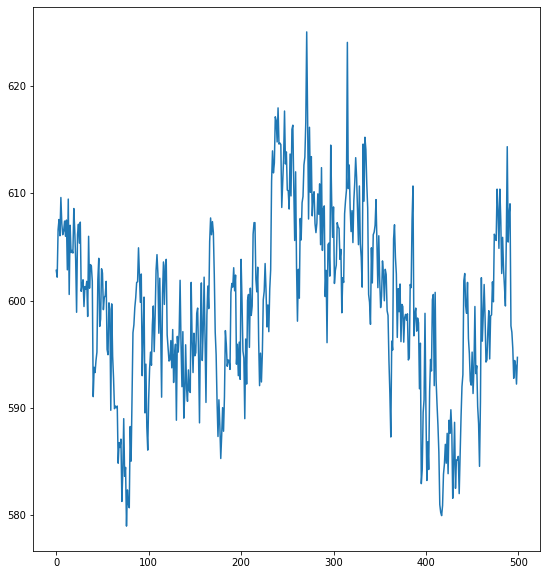

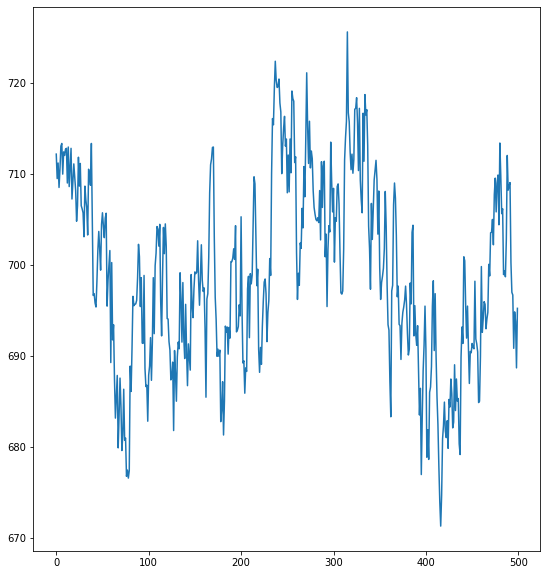

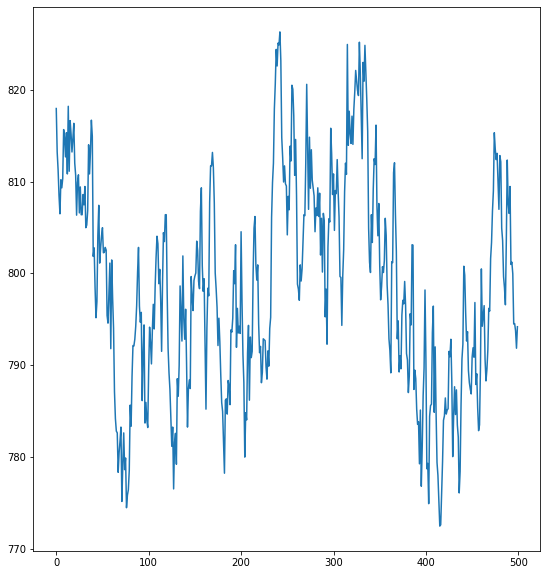

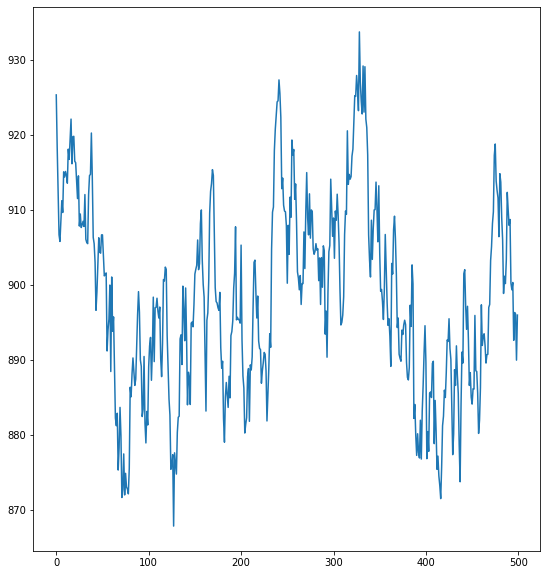

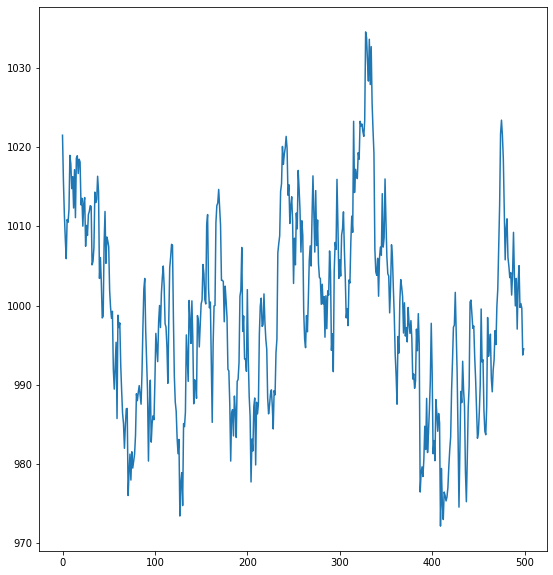

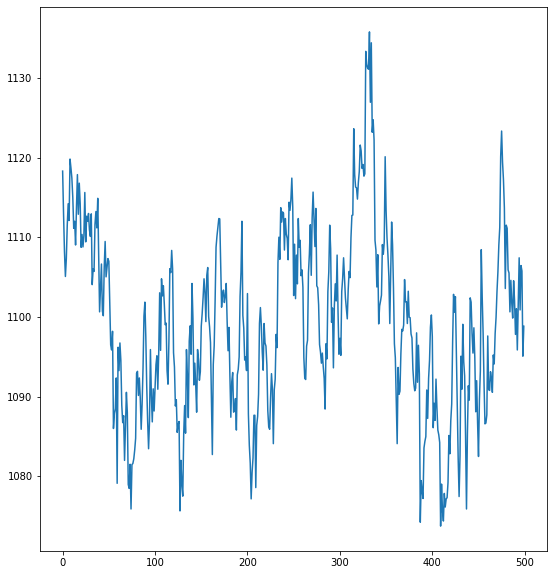

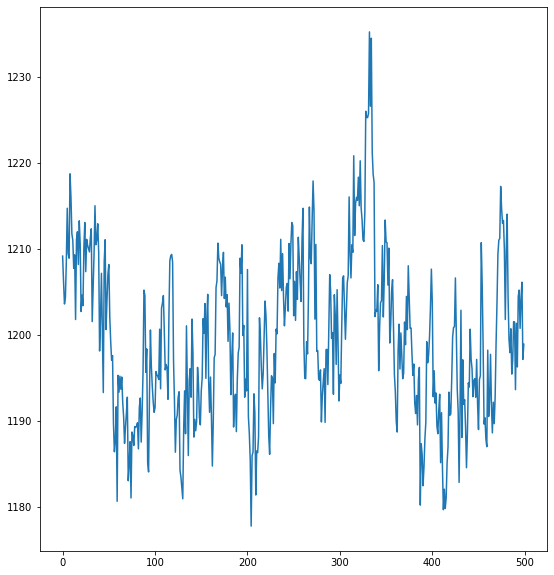

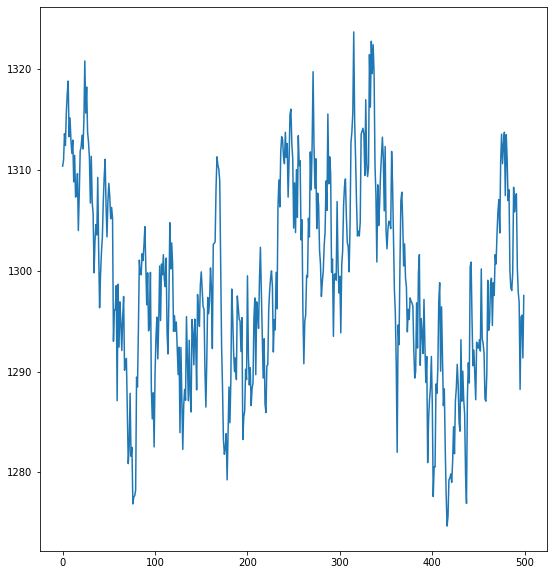

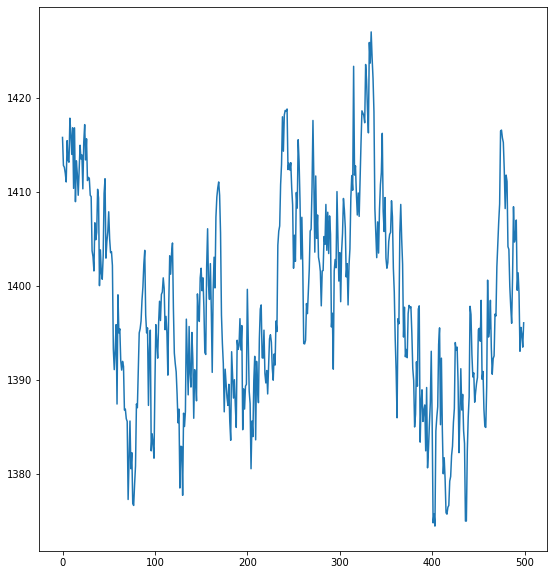

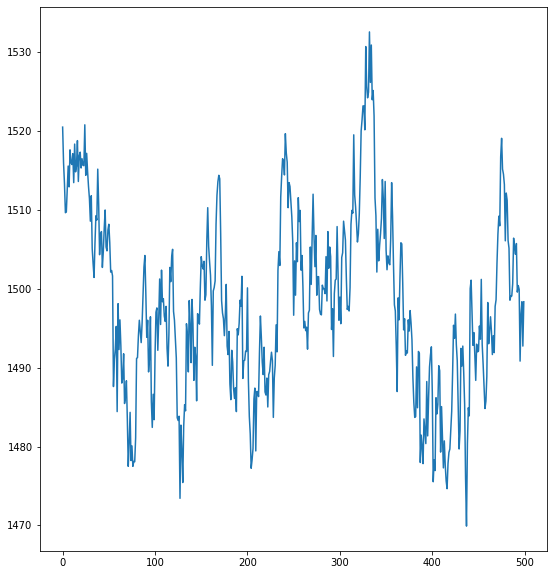

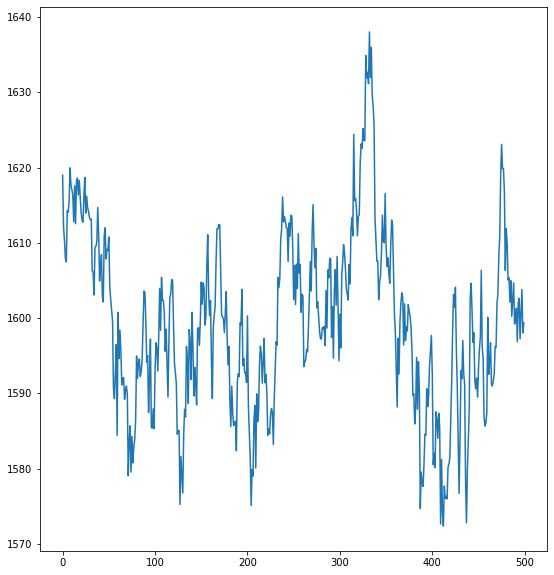

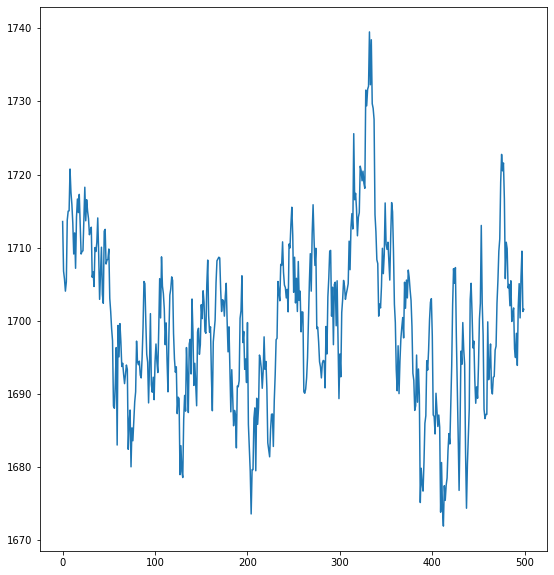

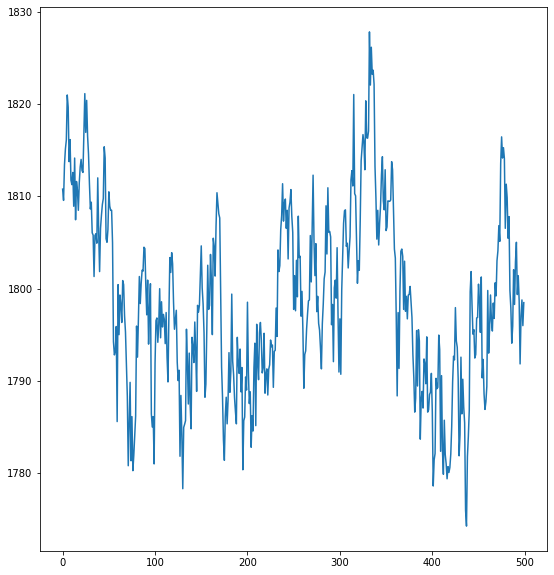

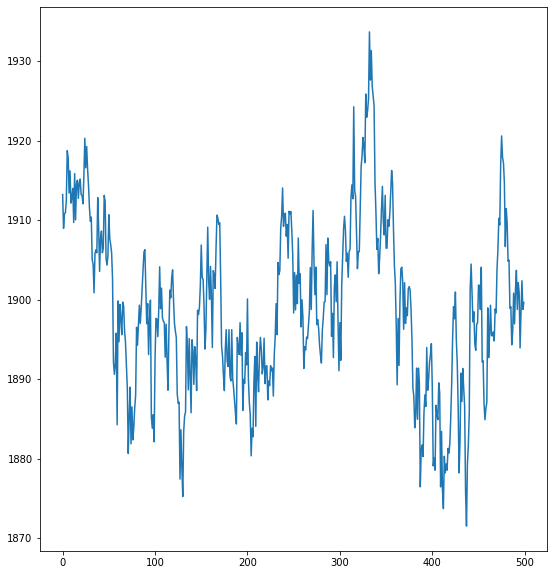

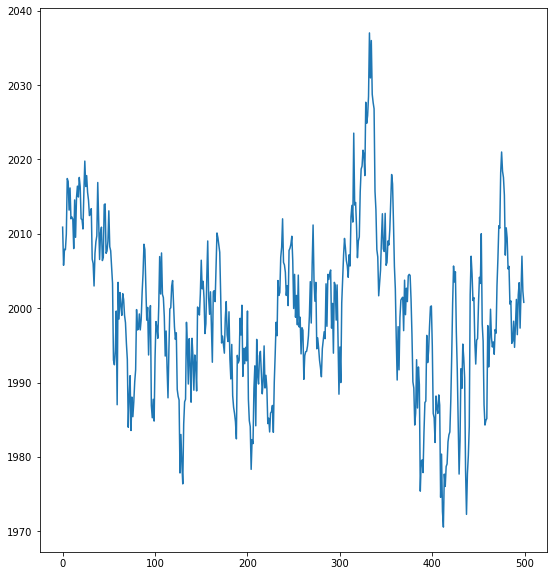

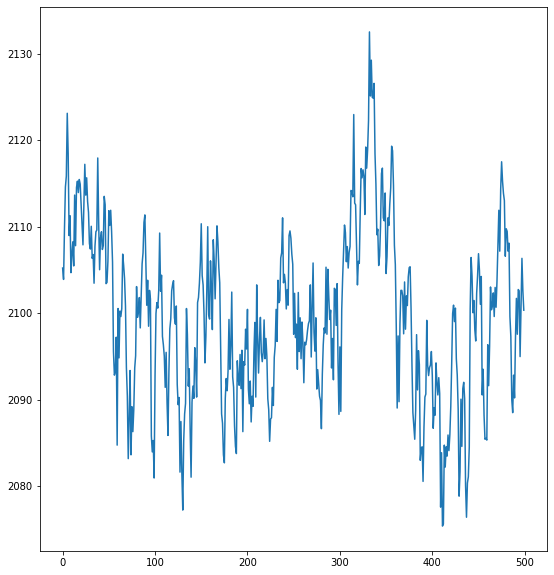

In [ ]:
#creamos el lienzo
fig1 = plt.figure(figsize=(20, 10,))
ax2 = fig.add_subplot(1, 2, 2)
#graficamos la cantidad de canales que queramos
for canal in range(data.shape[1]):
  fig = plt.figure(figsize=(20, 10,))
  ax = fig.add_subplot(1, 2, 2)
  for epoca in range (int(data.shape[2]/150)):
    ax.plot( data[:,canal,epoca] + canal*100)
  plt.show()


In [ ]:
#Raíz de la media cuadrática o RMS es una medida estadística de la magnitud de una cantidad variable. 
#Puede calcularse para una serie de valores discretos o para una función matemática de variable continua.
def valrms(senal):
  N=len(senal)
  x=0
  for i in senal:
    x = x + i**2;
    rms=np.sqrt(x/N)
    return rms

In [ ]:
#creamos un ciclo en donde se le saquen ciertas caracteristicas a la señal
#para cada uno de los canales

for c in range(int(data.shape[0]/40)):

  promedio = round(np.mean(c),3)
  desviacion = round(np.std(c),3)
  minim = round(np.min(c),3)
  maxim = round(np.max(c),3)
  kur = round(kurtosis(c,fisher=True),3)

  
              

# FILTRADO 

In [ ]:
#%% Cargar Datos

fs=250
print('Loading',filename,'with sampling frequency of',fs,'Hz.')
data = sio.loadmat(filename)
Xdata = data['X'];labels = data['labels'].reshape(-1,);
ind=np.where((labels==1) | (labels==2))[0]
Xdata=Xdata[:,:,ind] #Tiempo x canales x trials
labels=labels[ind]
ind = np.argsort(labels)

Loading /content/drive/MyDrive/bioingenieria/Dataset_IA/NEW_22ch_A01.mat with sampling frequency of 250 Hz.


In [ ]:
#%% Filtrado
b,a= butter(5, [8.0/(0.5*fs), 30.0/(0.5*fs)], btype='band')
Xdata = filtfilt(b,a, Xdata, axis=0)
Xdata = np.transpose(Xdata,(2,1,0))

# ICA y KURTOSIS


In [ ]:
 #%% kur
def KUR(S_, A_,m_, n):#puedo eliminar hasta dejar 1 o 2 componenetes ese valor es n
    k = kurtosis(S_) #Kurtosis de cada IC

    if(n >= len(A_)):
        n = len(A_) - 1

    ind = np.argsort(k)[:-1-n]
    Strun = S_[:,ind]
    Atrun = A_[:,ind]
    
    Xrec = np.dot(Strun, Atrun.T) + m_
    
    return Xrec


In [ ]:
#%% ICA
S = []
A = []
means = []
for trial in range(len(Xdata)):
    ica = FastICA(n_components=len(Xdata[0]))
    S_ = ica.fit_transform(Xdata[trial].T)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    m_ = ica.mean_
    S.append(S_)
    A.append(A_)
    means.append(m_)
    # We can `prove` that the ICA model applies by reverting the unmixing.
    if not(np.allclose(Xdata[trial].T, np.dot(S_, A_.T) + m_)):
        print('Fallo en la estimación')


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tole

#Machine learning

In [ ]:

skf = StratifiedKFold(n_splits=5)

cv_results = []
cv_results2 = []
cv_results3 = []

#Ciclo del número de componentes a filtrar
for n_ica in range(20):
    #Filtramos todos los trials según MAC
    Xf = np.array([KUR(S[trial], A[trial],means[trial], n_ica) for trial in range(len(S))])
    Xf = np.transpose(Xf,[0,2,1])
    #Ciclo de número de componentes en CSP
    for n_components in range(2,Xf.shape[1],2):
        #Ciclo de validación cruzada
        acc=[]
        acc2=[]
        acc3=[]
        for tr,val in skf.split(labels,labels):
            csp = CSP(n_components=n_components).fit(Xf[tr],labels[tr])
            features = csp.transform(Xdata)

            #linear discrimination
            clf=LDA().fit(features[tr],labels[tr])
            acc.append(clf.score(features[val],labels[val]))
            #g=clf.predict(features[tr])

            #Bayes
            clf = GaussianNB()
            clf=clf.fit(features[tr],labels[tr]) 
            acc2.append(clf.score(features[val],labels[val]))
            #g3=clf.predict(features[tr])
           
            # support vector machine
            clf = svm.SVC()
            clf=clf.fit(features[tr],labels[tr]) 
            acc3.append(clf.score(features[val],labels[val]))
           # g2=clf.predict(features[tr])

        cv_results.append({'n_ica':n_ica,'n_components':n_components,'scores':acc,'mean_score':np.mean(acc),'std_score':np.std(acc)})
        cv_results2.append({'n_ica':n_ica,'n_components':n_components,'scores':acc2,'mean_score':np.mean(acc2),'std_score':np.std(acc2)})    
        cv_results3.append({'n_ica':n_ica,'n_components':n_components,'scores':acc3,'mean_score':np.mean(acc3),'std_score':np.std(acc3)})



Se han truncado las últimas 5000 líneas del flujo de salida.
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9 (2.2e-16 eps * 22 dim * 2e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.5 (2.2e-16 eps * 22 dim * 1.9e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 10 (2.2e-16 eps * 22 dim * 2.1e+15  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with r

In [ ]:
#%% Results           
best2 = max(cv_results2, key=lambda x:x['mean_score'])
print("___________modelo svc____________")
print(best2)
print("----------------------------------")
#print(g2)
#df = pd.DataFrame(cv_results)


best = max(cv_results, key=lambda x:x['mean_score'])
print("___________modelo LDA____________")
print(best)
print("------------")
#print(g)

best3 = max(cv_results3, key=lambda x:x['mean_score'])
print("___________modelo bayes____________")
print(best3)
print("------------")
#print(g3)


___________modelo svc____________
{'n_ica': 2, 'n_components': 20, 'scores': [0.8620689655172413, 0.8620689655172413, 0.9655172413793104, 0.896551724137931, 0.8214285714285714], 'mean_score': 0.8815270935960591, 'std_score': 0.04826832151826186}
----------------------------------
___________modelo LDA____________
{'n_ica': 0, 'n_components': 6, 'scores': [0.9655172413793104, 0.896551724137931, 0.896551724137931, 0.8620689655172413, 0.8928571428571429], 'mean_score': 0.9027093596059114, 'std_score': 0.0339687231685898}
------------
___________modelo bayes____________
{'n_ica': 6, 'n_components': 10, 'scores': [0.896551724137931, 0.9655172413793104, 0.9655172413793104, 0.9655172413793104, 0.9285714285714286], 'mean_score': 0.9443349753694582, 'std_score': 0.027848855221876995}
------------
